In [1]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from scipy.special import iv
from statsmodels.tsa.arima.model import ARIMA

In [2]:
def mets_filter(ts,rho,alpha):
    ts_mean = np.mean(ts)
    ts = np.append(ts,ts_mean)
    sample_size = len(ts)
    
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1

    L_approx[sample_size -1 ] = np.zeros(sample_size)
    filter_matrix = expm(rho*L_approx)
    
    output = np.dot(filter_matrix,ts) + alpha

    return output[:-1]


def ols_mets(ts, grid_size):
    sample_size = len(ts)
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1
    
    min_rho =  0.0
    filter_matrix = expm(min_rho*L_approx)
    resid = np.dot(filter_matrix,ts)
    min_alpha =  np.mean(resid)
    min_obj = np.square(np.std(resid))
    
    for rho in np.linspace(-2,2,grid_size):
        filter_matrix = expm(rho*L_approx)
        resid =  np.dot(filter_matrix,ts)
        alpha =  np.mean(resid)
        obj = np.square(np.std(resid))
        
        if obj < min_obj:
            min_alpha = alpha
            min_rho = rho
            min_obj = obj

    return [min_alpha, min_rho, min_obj]    

In [196]:
time_length = 30
data = pd.DataFrame(columns  = range(0,time_length))


for index in range(0,100):
#     ts = np.random.normal(0,2,2)
#     for time in range(2,time_length):
#         ts= np.append(ts, .7*ts[-1] -.1*ts[-2]+ np.random.normal(0,1))

    ts = np.random.uniform(-5,5)*np.cos(np.linspace(0,30,time_length)) + np.random.normal(0,1,time_length)

    data.loc[index] = ts
    
data.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-1.804802,-1.020706,1.012709,1.007989,1.070146,-1.615644,-1.130789,-1.893942,0.685761,0.940128,...,0.303789,2.973730,-1.120780,-0.391024,-3.018687,0.851459,0.234836,0.761584,1.277692,0.031936
1,1.895373,0.405951,0.046235,-1.022405,1.265131,1.718062,5.117852,0.930501,-0.691195,-1.938390,...,-2.153717,-2.564777,-0.980344,1.905517,0.285141,2.735833,-1.679300,-2.375646,-3.416783,1.643877
2,-0.037311,1.466184,-1.893621,-1.201331,-0.192698,-0.891768,0.611029,1.639449,-0.372398,-0.295828,...,-0.670506,-0.374759,-0.498747,-0.357690,-1.012112,0.458350,-0.233318,-1.787993,-2.441502,0.025194
3,-1.333085,-0.335378,-0.290454,1.119621,0.349191,0.408209,0.443123,-0.785437,1.211983,0.568821,...,0.665645,-2.367642,-1.109318,2.078387,-0.449542,0.983245,0.262014,1.173025,0.773106,0.334816
4,-4.134583,-1.091097,2.729842,4.363452,1.034025,-1.184692,-3.450088,-2.496574,0.825470,3.663910,...,0.017683,3.640742,2.083584,-0.771001,-2.646229,-2.139421,1.309625,3.843809,4.474196,-0.236520


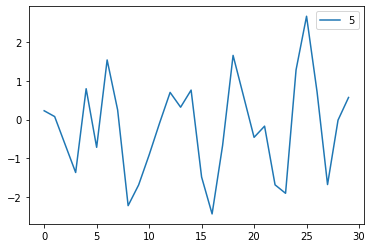

In [197]:
pd.DataFrame(data.loc[5]).plot()

In [198]:
ar_mse = []
mets_mse  = []

ar_coef = []
mets_coef = []

for index in data.index:
    ts = data.loc[index].values
    mets_model = ols_mets(ts, 50)
    mets_mse.append(mets_model[2] )
    mets_coef.append(-1*mets_model[1])
    
    ar_model = ARIMA(ts,order = (1,0,0)).fit()
    ar_mse.append(np.mean(np.square(ts- ar_model.predict())))
    ar_coef.append(ar_model.params[1])

In [199]:
error_df = pd.DataFrame({'mets_mse':mets_mse, 'ar_mse':ar_mse})
error_df.head()

,mets_mse,ar_mse
0,2.344935,2.347774
1,4.383430,4.634609
2,1.260668,1.301749
3,0.895328,0.895194
4,3.845075,5.912193


In [200]:
len(error_df.query('mets_mse < ar_mse'))/len(error_df)

0.89

In [201]:
len(error_df)

100

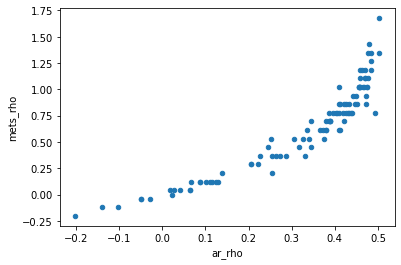

In [202]:
coef_df = pd.DataFrame({'mets_rho':mets_coef, 'ar_rho':ar_coef})
coef_df.plot.scatter(x='ar_rho',y='mets_rho')

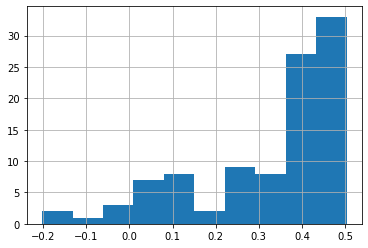

In [203]:
coef_df['ar_rho'].hist()

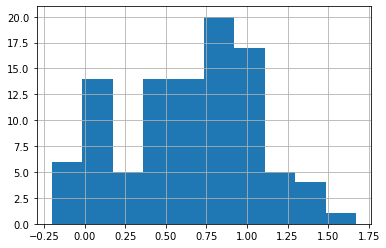

In [204]:
coef_df['mets_rho'].hist()

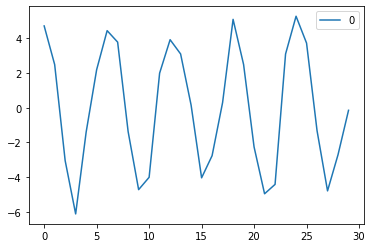

In [205]:
pd.DataFrame(ts).plot()

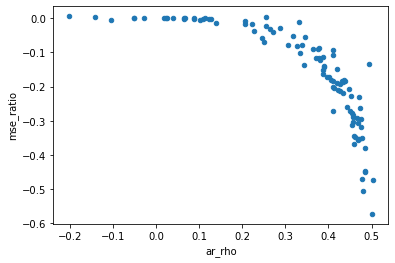

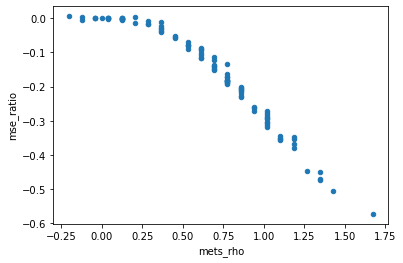

In [206]:
fitted_df = pd.DataFrame({'mets_rho':mets_coef, 'ar_rho':ar_coef,
                         'mets_mse':mets_mse, 'ar_mse':ar_mse})
fitted_df['mse_ratio'] = (fitted_df['mets_mse'] - fitted_df['ar_mse'])/fitted_df['ar_mse']
fitted_df.plot.scatter(x='ar_rho',y = 'mse_ratio')
fitted_df.plot.scatter(x='mets_rho',y = 'mse_ratio')

In [207]:
print(fitted_df['mse_ratio'].mean())
print(fitted_df['mse_ratio'].median())

-0.1578962951579313
-0.13853785925840312


In [208]:
coef_df.corr()

,mets_rho,ar_rho
mets_rho,1.000000,0.921372
ar_rho,0.921372,1.000000
